In [22]:
from qdisk.model import Keplerian_velocity
from qdisk.classes import FitsImage
from qdisk.plot import Map, ChannelMap
import eDiskplot as eplot
import analysis_utils as au
from eDisk_source_dict import source_dict
import numpy as np
import matplotlib.pyplot as plt
from astropy.convolution import convolve_fft, Gaussian2DKernel
from qdisk.utils import FWHM_to_sigma
%matplotlib widget
%load_ext autoreload
%autoreload 2

source = "L1489IRS"
config = "SBLB"
line = "SO"
robust = 1.0
center_coord = source_dict[source]["radec"]
PA = source_dict[source]["PA"]
incl = source_dict[source]["incl"]
distance = source_dict[source]["distance"]
vsys = source_dict[source]["v_sys"]
vrange = 9

rotmapname = au.VADPpath + au.get_image_basename(source, config, line, robust=robust).replace(".fits", "_v0.fits")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


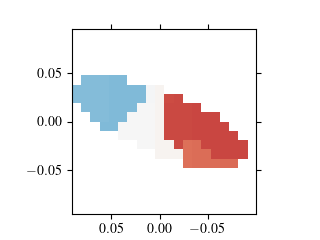

In [38]:
rout = 0.1
rotmap = Map(rotmapname, data_scaling_factor=1e-3, center_coord=center_coord, xlim=(-rout, rout), ylim=(-rout, rout))
mask = rotmap.mask(rmin=0.01, rmax=rout, PA=PA, incl=incl)
r, t = rotmap.get_disk_coord(PA=PA, incl=incl)
rotmap.plot_colormap(cmap=eplot.cmap["M1"], vmin=vsys-vrange, vmax=vsys+vrange)

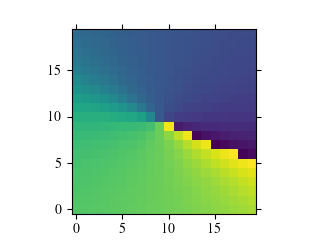

In [39]:
plt.figure()
plt.imshow(t, origin="lower")

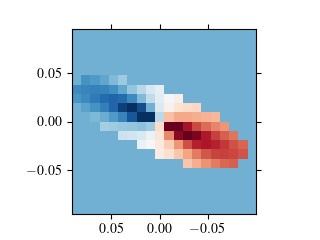

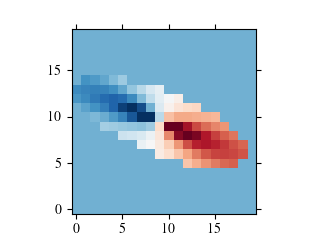

In [40]:
Mstar = 1.6
vlos = - Keplerian_velocity(r=r*distance, theta=t, Mstar=Mstar, incl=incl) + vsys
kernel = Gaussian2DKernel(x_stddev=FWHM_to_sigma(rotmap.bmaj)/rotmap.dpix, y_stddev=FWHM_to_sigma(rotmap.bmin)/rotmap.dpix, theta=np.radians(90+rotmap.bpa))
# vlos = convolve_fft(vlos, kernel)
fig, ax = plt.subplots()
ax.pcolorfast(rotmap.x, rotmap.y, vlos*mask, vmin=vsys-vrange, vmax=vsys+vrange, cmap=eplot.cmap["M1"])
ax.invert_xaxis()
ax.set(aspect=1./ax.get_data_ratio())

plt.figure()
plt.imshow(vlos*mask, vmin=vsys-vrange, vmax=vsys+vrange, cmap=eplot.cmap["M1"], origin="lower")

In [41]:
sigma = 0.3
vrange = 15
v = np.arange(vsys-vrange, vsys+vrange, 0.1)
# I = 2 * r ** (-1.5)
vcube = 1 * np.exp(- (v[:, None, None] - vlos[None, :, :]) ** 2 / (2 * sigma**2))
# vcube = np.array([convolve_fft(im, kernel) for im in vcube])

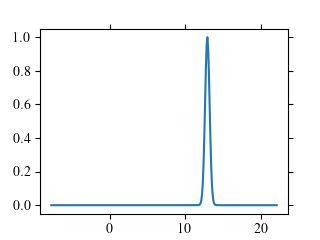

In [46]:
plt.figure()
plt.plot(v, vcube[:, 10, 11])

In [12]:
def model(Mstar, incl, PA, vsys):
    r, t = rotmap.get_disk_coord(PA=PA, incl=incl)
    vlos = - Keplerian_velocity(r=r*distance, theta=t, Mstar=Mstar, incl=incl) + vsys
    vlos = convolve_fft(vlos, kernel)
    return vlos

In [13]:
# uncertainty
dv0 = FitsImage(rotmapname.replace("_v0.fits", "_dv0.fits"), xlim=(-rout, rout), ylim=(-rout, rout))
rms = dv0.data*1e-3*mask

In [14]:
from mcmc_tools import log_prior, emcee_run_wrapper

# set up parameters
param = [1.6, 73, 69, 7.22]
bound = [(0.5, 10), (0, 90), (0, 90), (4, 10)]

def log_likelihood(param):
    vlos = model(*param)
    # compute log likelihood
    ll = -0.5 * np.nansum((rotmap.data - vlos*mask) ** 2 / rms ** 2)

    return ll

def log_probability(param):
    lp = log_prior(param, bound)
    if not np.isfinite(lp):
        return -np.inf
    ll = log_likelihood(param)
    return lp + ll

In [15]:
import multiprocessing

with multiprocessing.Pool(16) as pool:
    sampler, sample = emcee_run_wrapper(log_probability=log_probability, initial_state=param, nstep=500, pool=pool)

starting to run the MCMC sampling with: 
 	 initial state: [1.6, 73, 69, 7.22] 
 	 number of walkers: 200 
 	 number of steps: 600 including 100 steps as burn in


100%|██████████| 600/600 [00:55<00:00, 10.88it/s]


In [16]:
# get best fit param and model
sample_flat = sampler.get_chain(flat=True)
best_param = sample_flat[np.argmax(sampler.get_log_prob(flat=True))]
best_model = model(*best_param)

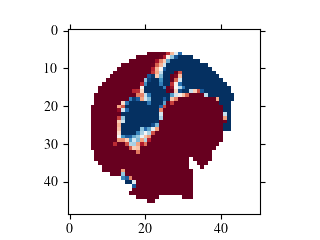

In [17]:
plt.figure()
plt.imshow(rotmap.data - best_model, vmin=-0.5, vmax=+0.5, cmap=eplot.cmap["M1"])

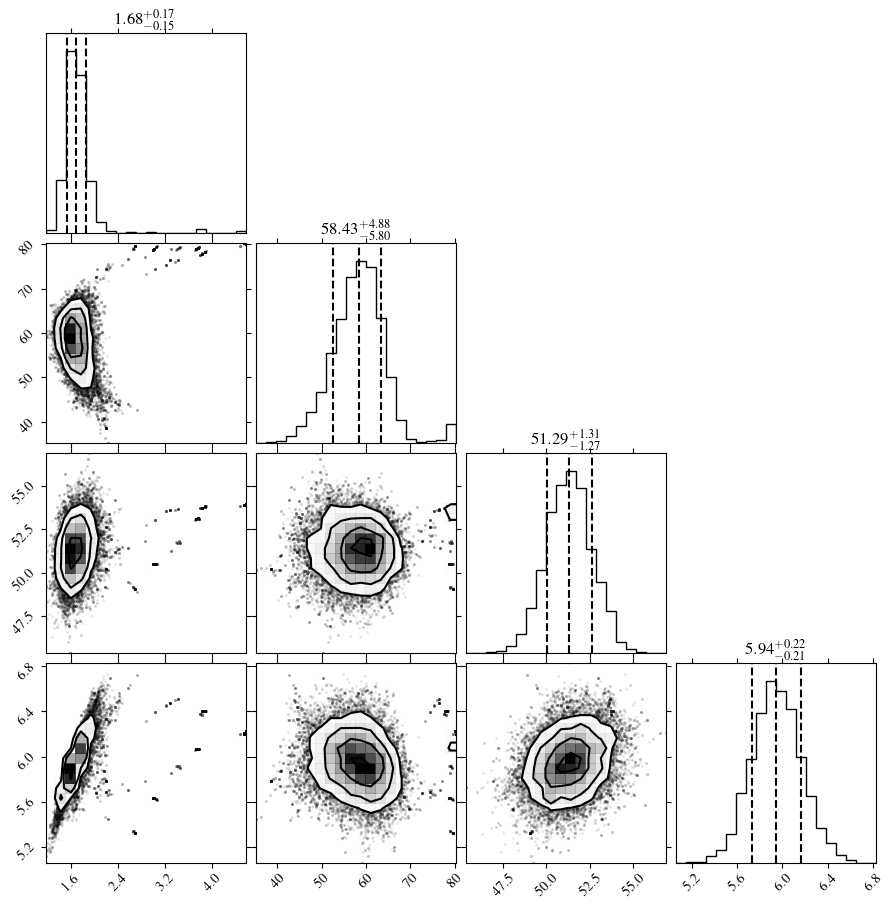

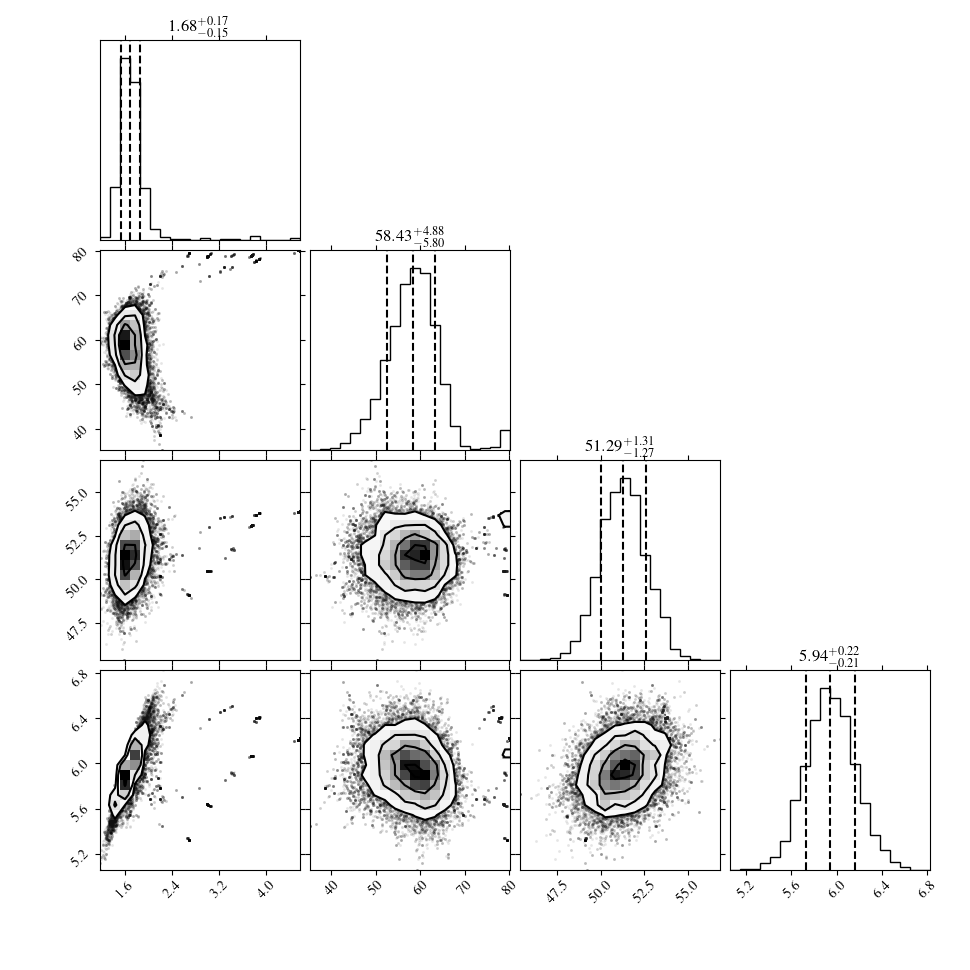

In [18]:
from mcmc_tools import plot_corner

plot_corner(sample[300:])